In [1]:
import pandas as pd
import yfinance as yf

from statsmodels.graphics import tsaplots
from statsmodels.tsa.statespace.sarimax import SARIMAX
from calendar import monthrange
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.dates as mdates

In [2]:
# get risk free rate
rf = yf.Ticker('^IRX')
# get historical data for last 5 years
rf = rf.history(period='10y')



In [53]:
products = {'Corn': 'ZC', 
            'Soybean': 'ZS', 
            'Wheat': 'ZW', 
            'Oats': 'ZO',
            'Rice': 'ZR',}

# months = ['H', 'K', 'N', 'U']  # March, May, July, September

# get all futures prices and make one big dataset
df_futures = pd.DataFrame()

for product in products:
    value = f'{products[product]}=F'
    futures = yf.Ticker(value)
    futures = futures.history(period='10y')
    df_futures[product] = futures['Close']
    # make date one of the columns


# add risk free rate of each date to the dataset

rf = yf.Ticker('^IRX')
rf = rf.history(period='10y')

df_futures['Datetime'] = df_futures.index
df_futures.reset_index(drop=True, inplace=True)
df_futures['Date'] = df_futures['Datetime'].dt.date
rf['Datetime'] = rf.index
rf.reset_index(drop=True, inplace=True)
rf['Date'] = rf['Datetime'].dt.date
rf['Return'] = rf['Close'].pct_change()

df_futures = df_futures.merge(rf[['Date', 'Return']], on='Date', how='left')
df_futures.rename(columns={'Return': 'rf'}, inplace=True)


In [48]:
df_futures.dropna(inplace=True)
df_futures

,Corn,Soybean,Wheat,Oats,Rice,Datetime,Date,rf
0,338.25,971.50,488.50,342.25,1262.0,2014-09-18 00:00:00-04:00,2014-09-18,-0.230769
1,331.50,957.00,474.50,337.25,1270.0,2014-09-19 00:00:00-04:00,2014-09-19,-0.300000
2,330.25,938.25,476.75,336.50,1255.0,2014-09-22 00:00:00-04:00,2014-09-22,-0.571429
3,325.50,936.25,476.00,332.75,1266.0,2014-09-23 00:00:00-04:00,2014-09-23,1.333333
4,329.50,936.75,480.25,340.50,1273.0,2014-09-24 00:00:00-04:00,2014-09-24,0.000000
...,...,...,...,...,...,...,...,...
2506,379.50,977.50,558.75,358.25,1512.0,2024-09-10 00:00:00-04:00,2024-09-10,-0.012257
2507,380.50,979.75,563.75,358.75,1535.5,2024-09-11 00:00:00-04:00,2024-09-11,0.008273
2508,386.25,991.50,563.00,366.25,1549.5,2024-09-12 00:00:00-04:00,2024-09-12,-0.007179
2509,390.75,986.75,571.25,366.25,1549.5,2024-09-13 00:00:00-04:00,2024-09-13,-0.015909


In [49]:
# compute sharp ratio for each product in each year
sharp_ratios = {}

for product in products:
    df_futures[f'{product}_return'] = df_futures[product].pct_change()
    df_futures[f'{product}_excess_return'] = df_futures[f'{product}_return'] - df_futures['rf']
    # compute sharp ratio for each year
    sharp_ratios[product] = {}
    for year in range(2015, 2024):  # only data with full years
        df_year = df_futures[df_futures['Datetime'].dt.year == year]
        sharp_ratio = df_year[f'{product}_excess_return'].mean() / df_year[f'{product}_excess_return'].std()
        annualized_sharp_ratio = sharp_ratio * (252 ** 0.5)
        sharp_ratios[product][year] = annualized_sharp_ratio

In [54]:
print('Yearly Sharpe Ratio For Each Product (Compared to Risk Free Rate based on 3 month treasury bill)')
for product in sharp_ratios:
    print(product)
    for year in sharp_ratios[product]:
        print(f'{year}: {sharp_ratios[product][year]}')
    print('\n')

Yearly Sharpe Ratio For Each Product (Compared to Risk Free Rate based on 3 month treasury bill)
Corn
2015: -3.516223306507166
2016: -1.5182527232324277
2017: -2.5845775702995333
2018: -2.009376223124832
2019: 1.5892028677142187
2020: 0.8983246753264268
2021: -1.6436277598048479
2022: -4.089507339183072
2023: -1.4898806199016659


Soybean
2015: -3.5201592379326403
2016: -1.4218516399728134
2017: -2.8824237500066787
2018: -2.582910395311469
2019: 2.0762783979388844
2020: 0.907946186479025
2021: -1.6988795737068176
2022: -4.132094534726096
2023: -1.425328178618341


Wheat
2015: -3.5275869118301646
2016: -1.5826164412083972
2017: -2.319385587736925
2018: -1.0216839535654743
2019: 1.6805147756263659
2020: 0.888736476398857
2021: -1.6542403842362274
2022: -3.912465303827852
2023: -0.9546497207081237


Oats
2015: -3.5265680509925614
2016: -1.4102311447449825
2017: -1.9893911971200078
2018: -1.074511413146682
2019: 1.4210761014474496
2020: 0.8998392008061844
2021: -1.5736345159908545
2022: -4

Now, we will compute the sharpe ratio on a bi-weekly basis, making it so that we will have more sharpe ratios that we can train a model on.

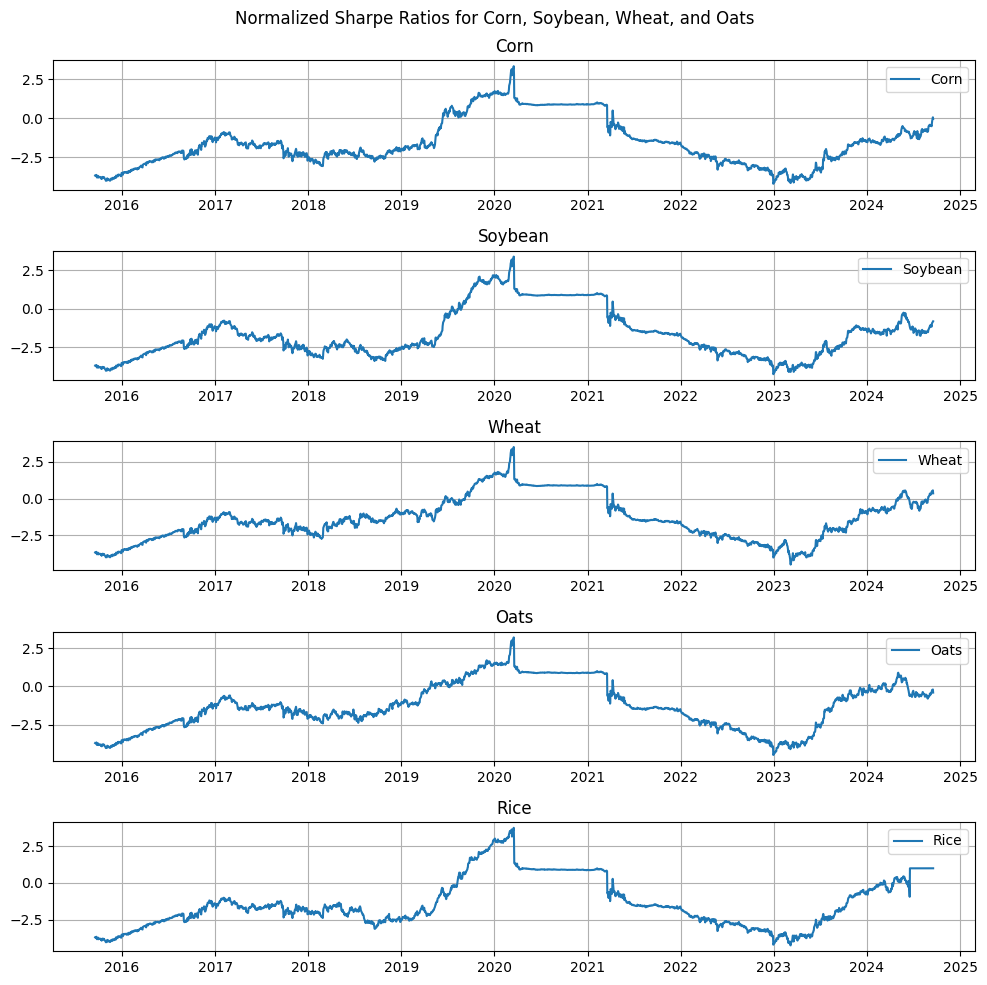

0.09233468792256641

In [67]:
WINDOW_SIZE = 252

normalized_sharpe_ratios = {}

for product in products:
    df_futures[f'{product}_return'] = df_futures[product].pct_change()
    df_futures[f'{product}_excess_return'] = df_futures[f'{product}_return'] - df_futures['rf']
    rolling_mean = df_futures[f'{product}_excess_return'].rolling(window=WINDOW_SIZE).mean()
    rolling_std = df_futures[f'{product}_excess_return'].rolling(window=WINDOW_SIZE).std()
    normalized_sharpe_ratios[product] = rolling_mean / rolling_std * (WINDOW_SIZE ** 0.5)

# plot normalized sharp ratio
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

# plot normalized sharp ratio in 4 subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 10))
fig.suptitle('Normalized Sharpe Ratios for Corn, Soybean, Wheat, and Oats')
for i, product in enumerate(products):
    axs[i].plot(df_futures['Datetime'], normalized_sharpe_ratios[product], label=product)
    axs[i].xaxis.set_major_locator(mdates.YearLocator())
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    axs[i].set_title(product)
    axs[i].legend()
    axs[i].grid()
plt.tight_layout()
plt.show()


(normalized_sharpe_ratios['Corn'].dropna() - normalized_sharpe_ratios['Soybean'].dropna()).mean()


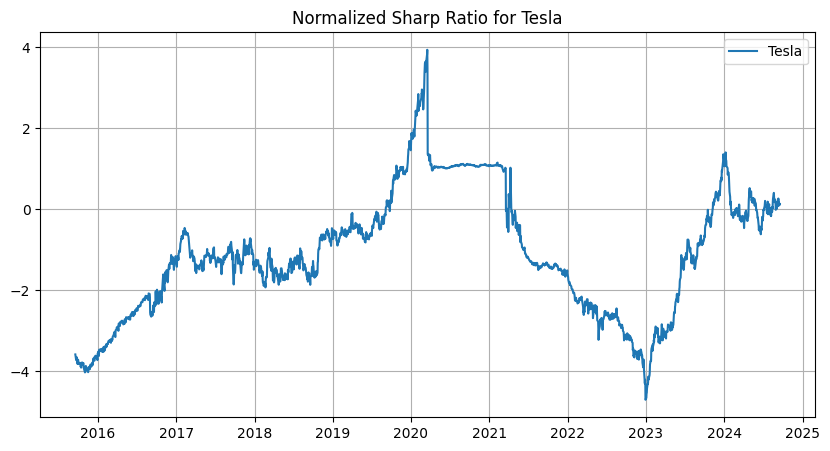

In [65]:
# plot normalzied sharp artio for tesla

tesla = yf.Ticker('TSLA')
tesla = tesla.history(period='10y')
tesla['Return'] = tesla['Close'].pct_change()
tesla['Datetime'] = tesla.index
tesla.reset_index(drop=True, inplace=True)
tesla['Date'] = tesla['Datetime'].dt.date
tesla['rf'] = rf['Close'].pct_change()
tesla['excess_return'] = tesla['Return'] - tesla['rf']
tesla['rolling_mean'] = tesla['excess_return'].rolling(window=WINDOW_SIZE).mean()
tesla['rolling_std'] = tesla['excess_return'].rolling(window=WINDOW_SIZE).std()
tesla['normalized_sharp_ratio'] = tesla['rolling_mean'] / tesla['rolling_std'] * (WINDOW_SIZE ** 0.5)

plt.figure(figsize=(10, 5))
plt.plot(tesla['Datetime'], tesla['normalized_sharp_ratio'], label='Tesla')
plt.title('Normalized Sharp Ratio for Tesla')
plt.legend()
plt.grid()
plt.show()
